<a href="https://colab.research.google.com/github/vorst4/TUE_5LSM0_g6/blob/master/TUE_5LSM0_g6_dennis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# ------------------------------ Import modules ------------------------------ #

import os
import sys
import json
import importlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from glob import glob
from datetime import datetime
from PIL import Image
from google.colab import drive

try:
  import rdp
except:
  !pip install rdp
  import rdp

# --------------------------------- Constants -------------------------------- #

N_classes = 9

N_train = 22799
N_val = 2532
N_test = 8238


# ---------------------- Import modules from Git source ---------------------- #

# efficient net
try:
  from src.efficientnet.efficientnet_pytorch.model import EfficientNet
except:
  print('\nInstalling efficient-net...')
  !pip install -e git+https://github.com/lukemelas/EfficientNet-PyTorch#egg=EfficientNet
  from src.efficientnet.efficientnet_pytorch.model import EfficientNet
  print('Done')

# shap
try:
  import shap
except:
  print('\nInstalling shap...')
  !pip install shap
  import shap
  print('Done')


# ----------------------------- Initialize Colab ----------------------------- #
#
# NOTE: all console commands (the ones that start with !) cannot be run from a 
# .py script. Usually this is possible using the command 'os.system('...')'.
# However, in Colab, it is for some reason not possible to obtain the console
# output of the command that is run. This makes it impossible to notify the user
# if an error occurs. All the commands therefore need to be run in the main
# .ipynb script (which is this script).
#


# check if GPU is enabled
if torch.cuda.is_available() == False:
  print('\nWARNING: GPU not enabled. Goto runtime -> change runtime type')


# mount Google Drive (if needed)
if not os.path.exists('drive'):
  print('\nMounting Google Drive...')
  drive.mount('/content/drive')
  print('Done')


# setup Git (if needed)
if not os.path.exists('TUE_5LSM0_g6'):
  print('\nSetting up git...')
  print('...Loading github.json from Google Drive')
  with open('/content/drive/My Drive/github.json', 'r') as json_file:
    gitconfig = json.load(json_file)
  print('...Cloning git repo')
  url = 'https://'+gitconfig["username"]+':'+gitconfig["key"]+\
        '@github.com/vorst4/TUE_5LSM0_g6.git'
  !git clone {url}
  print('...Setting username and email')
  !git -C TUE_5LSM0_g6 config user.name {gitconfig["username"]}
  !git -C TUE_5LSM0_g6 config user.email {gitconfig["email"]}
  print('Done')


# remove default sample_data folder (if needed)
if os.path.exists('sample_data'):
  print('\nRemoving sample_data...')
  os.system('rm -r sample_data')
  print('Done')


# copy and unzip data from Google Drive (if needed)
if not os.path.exists('ISIC_2019_Test_Input'):
  print('\nGetting data...')
  print('...Copying data.zip from Google Drive to workfolder')
  !cp 'drive/My Drive/5LSM0-final-assignment/data.zip' .
  print('...Unpacking data.zip')
  !unzip -q data.zip
  print('...Removing data.zip')
  !rm data.zip
  print('Done\n')


# ----------------------------- Import Functions ----------------------------- #
#
# NOTE: The modules need to be forcibly reloaded because Colab does not do this
# by default, even if the module has changed.
#

# append git dir to systems paths
sys.path.append('TUE_5LSM0_g6')

# # dataloaders
# import dataloaders
# importlib.reload(dataloaders)
# dataloaders = dataloaders.dataloaders

# dataloaders
import dataloaders_augmentation
importlib.reload(dataloaders_augmentation)
dataloaders_augmentation = dataloaders_augmentation.dataloaders

# train & accuracy
import train2
importlib.reload(train2)

# resnet18
import resnet18
importlib.reload(resnet18)
resnet18 = resnet18.resnet18

# restore
import restore2
importlib.reload(restore2)
restore2 = restore2.restore2

# score
import score
importlib.reload(score)
Score = score.Score

# cam
import class_activation_map as cam
importlib.reload(cam)

# isic_challenge_scoring (module, that does not change)
import isic_challenge_scoring
from isic_challenge_scoring.classification import ClassificationScore


# --------------------------------- Settings --------------------------------- #

# settings object
S = type('Settings', (), {})()

# use gpu/cpu
if torch.cuda.is_available():
  S.device = torch.device('cuda')
else:
  S.device = torch.device('cpu')

# image size (squared)
S.modelname = 'efficientnet-b0'
S.img_size = EfficientNet.get_image_size(S.modelname)

# set variable type
S.dtype = torch.float32

# when to print
S.evaluate_every = 200

# number of epochs to run
S.epochs = 10

# batch size, increase this until the RAM is full
S.batch_size = 32

# percentage of original train set that is to be used for validation
# S.val_ratio = 10

# restore last backup of model?
S.load_backup = True

# Create backup each epoch?
S.backup_each_epoch = True


# model parameters
model_params = {
  'batch_norm_momentum': 0.99,
  'batch_norm_epsilon': 1e-3,
  'dropout_rate': 0.1,
  'drop_connect_rate': 0.1,
  'num_classes': N_classes }

# learning rate (with decay)
learning_rate = 5e-5
decayRate = 0.8


# ----------------------------------- Main ----------------------------------- #

# create data loader objects
dl_train, dl_val, dl_test = dataloaders_augmentation(batch_size=S.batch_size,
                                        img_size = S.img_size)

# create model
model = EfficientNet.from_name(S.modelname, model_params)

# link data loaders to model
model_hyperparam = type('HyperParameters', (), {})()
model_hyperparam.dl_train = dl_train
model_hyperparam.dl_val = dl_val
model_hyperparam.dl_test = dl_test

# load backup (if required)
if S.load_backup:
  model, model_data = restore2(model, S.modelname)
else:
  model_data = {}

# create score
model_hyperparam.score = Score(model, model_hyperparam)

# define optimizer
model_hyperparam.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# learning rate
model_hyperparam.lr_exp = optim.lr_scheduler.ExponentialLR(optimizer=model_hyperparam.optimizer, gamma=decayRate)

# # train
train2.Train(model, model_hyperparam, model_data, S)

# create csv file of test data
# make_cvs(model)

# label = 0
# print( model_hyperparam.score.calculate(2,2) )

# # model_hyperparam.score
# model_hyperparam.score._swap_single_label(5, 3)

# ----------------------------------- End ------------------------------------ #




Restored model




In [27]:
# ------------------------- GIT Pull, Commit & Push -------------------------- #

def git():

  if not input('\nPull? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 pull

  commit_msg = '\''+input('\nEnter commit message: ')+'\''

  if not input('\nCommit? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 add .
  !git -C /content/TUE_5LSM0_g6 commit -m {commit_msg}

  if not input('\nPush? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 push

git()

# ----------------------------------- End ------------------------------------ #



Pull? (y)y
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/vorst4/TUE_5LSM0_g6
   1782e5f..cc69919  master     -> origin/master
Updating 1782e5f..cc69919
Fast-forward
 TUE_5LSM0_g6_dennis.ipynb | 310 +++++++---------------------------------------
 1 file changed, 44 insertions(+), 266 deletions(-)

Enter commit message: -

Commit? (y)y
[master aafb364] -
 1 file changed, 20 insertions(+), 4 deletions(-)

Push? (y)y
Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 695 bytes | 695.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/vorst4/TUE_5LSM0_g6.git
   cc69919..aafb364  master -> master


Generated heatmap of random image. heatmap nv is the correct one


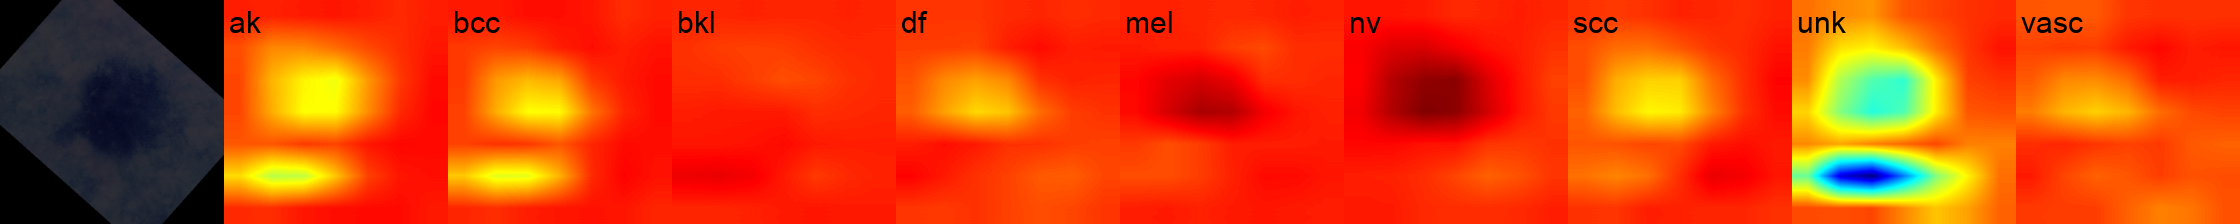

In [28]:


cam.display_random_heatmap(model, dl_train)



In [61]:


bool_load_prev = True
filepath = 'drive/My Drive/5LSM0-final-assignment/validation-scores.pkl'



import pickle

import gpu_memory_use
importlib.reload(gpu_memory_use)
gpu_memory_use = gpu_memory_use.gpu_memory_use

import model_performance
importlib.reload(model_performance)
model_performance = model_performance.model_performance

if not bool_load_prev:
  print(gpu_memory_use())
  y_true, scores = y_true, scores = model_performance(
      S, model_params, dl_val, N_val, N_classes)
  # with open(filepath, 'wb') as f:
  #   pickle.dump([y_true, scores], f)
else:
  with open(filepath, 'rb') as f:
    y_true, scores = pickle.load(f)


print('\n---------')


---------


In [0]:

import sklearn
import pandas as pd
import isic_challenge_scoring
importlib.reload(isic_challenge_scoring)


bool_use_weights = False

N_samples = y_true.shape[0]

# determine score probabilities
# p_scores = 1 / (1+ np.exp(-scores) )

a = 1
b = 0.5
p_scores = 1/((1 + np.exp(-(a*(scores - b)))))



# make sure that every label occurs at least once in y_true. This is done by 
# setting sample <i> to class <i> (basically the first 9 samples to each class)
for i in [3, 7]:
  # set y_true
  y_true[i] = i
  # also change p_scores such that the data isn't crap
  tmp = np.max(p_scores[i, :])
  idx = np.argmax(p_scores[i, :])
  p_scores[i, idx] = p_scores[i, i]
  p_scores[i, i] = tmp

# change y_true such that it has 9 columns, each with probability 0, 1
y_true2 = np.zeros((N_samples, N_classes))
for i in range(N_classes):
  y_true2[y_true==i, i] = 1
  

### weight ###
# determine number of images per label
N_imgs = np.zeros(N_classes)
for i in range(N_classes):
  N_imgs[i] = (y_true == i).sum()

# determine weight per label, depending on the (inverse) amount of images
w_lbl = 1/N_imgs
w_lbl = w_lbl / sum(w_lbl) # normalize it

# determine weight per image
if bool_use_weights:
  w = y_true2 * w_lbl
  w = np.sum(w, axis=1) # only 1 non-zero element per row
else:
  w = np.ones(y_true.shape)


sensitivity = sklearn.metrics.recall_score(y_true, np.argmax(p_scores, axis=1), average='weighted')


print('\n------------------------------------')
print('sensitivity = \t %i%%\t' % int(100*sensitivity))
print('y_true = \t', list(y_true.shape))
print('y_true2 = \t', list(y_true2.shape))
print('scores = \t', list(scores.shape))
print('n_labels = \t', len(np.unique(y_true)))
print('labels_pred = \t', np.unique(np.argmax(p_scores, axis=1)))
print('labels_true = \t', np.unique(y_true).astype(int))
print('p_scores = \t', list(p_scores.shape))
print('w = \t\t', list(w.shape))
print('------------------------------------\n')





------------------------------------
sensitivity = 	 59%	
y_true = 	 [2532]
y_true2 = 	 [2532, 9]
scores = 	 [2532, 9]
n_labels = 	 9
labels_pred = 	 [0 1 2 3 4 5 6 7 8]
labels_true = 	 [0 1 2 3 4 5 6 7 8]
p_scores = 	 [2532, 9]
w = 		 [2532]
------------------------------------



In [0]:

score = sklearn.metrics.roc_auc_score(y_true2, p_scores)

print(score)


0.8554969745537891


NameError: ignored

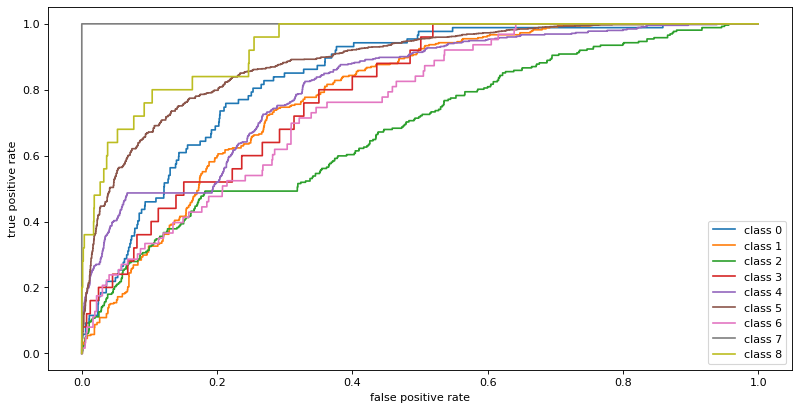

In [0]:

# roc_curve

import matplotlib.pyplot as plt

fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
# plt.hold()

for i in range(N_classes):
  fpr, tpr, thr = sklearn.metrics.roc_curve(y_true2[:, i], 
                                            p_scores[:, i], 
                                            sample_weight=w,
                                            drop_intermediate=False)

  plt.plot(fpr,tpr, label=('class %i' % i) )
  plt.ylabel('true positive rate')
  plt.xlabel('false positive rate')

plt.legend()
plt.show()


In [0]:

# confusion matrix
categories = (0, 1, 2, 3, 4, 5, 6, 7, 8)
y_pred = np.argmax(p_scores, axis=1)

confusion_matrix = sklearn.metrics.confusion_matrix( 
  y_true,
  y_pred,
  labels=categories,
  sample_weight=w)

print(np.round(100*confusion_matrix))



[[ 2700.  3300.  1700.     0.   600.   400.     0.     0.     0.]
 [ 2100. 25200.   900.     0.  1800.  3100.     0.     0.   100.]
 [ 3400.  5800.  5500.     0.  4400.  7100.     0.     0.     0.]
 [  100.  1200.   200.   100.     0.   900.     0.     0.     0.]
 [ 1400.  3800.  4200.     0. 23600. 12200.     0.     0.     0.]
 [  800. 14700.  4700.     0. 15800. 92300.     0.     0.   200.]
 [  700.  3900.   600.     0.   500.   500.   100.     0.     0.]
 [    0.     0.     0.     0.     0.     0.     0.   100.     0.]
 [    0.  1500.     0.     0.     0.   300.     0.     0.   700.]]


In [0]:

import pandas as pd

labels = dl_val.dataset.classes

yt = pd.DataFrame(y_true2, columns=labels)
p = pd.DataFrame(p_scores, columns=labels)
weight = pd.DataFrame({'score_weight': w, 'validation_weight': w})
# tmp = w/sum(w).astype(np.float64)
# weight.score_weight = pd.DataFrame((w/sum(w)).astype(np.float64))
# weight.validation_weight = pd.DataFrame((w/sum(w)).astype(np.float64))
# weight.score_weight = None

pl = yt.idxmax(axis='columns')
tl = p.idxmax(axis='columns')

confusion_matrix = sklearn.metrics.confusion_matrix( 
  pl,
  tl,
  labels=labels,
  sample_weight=weight.score_weight.values.reshape(-1) )

# print(np.round(100*confusion_matrix))

cf = confusion_matrix
# print(cf)

tpc = pd.Series(cf.diagonal(), index=labels)
# print('-- tp counts -----------------------')
# print(tpc)
# print('------------------------------------')

ww = weight.score_weight

tmp = ww.groupby(tl, sort=False)

tmp2 = tmp.sum()

tmp3 = tmp2.reindex(labels, fill_value=0)
# print(tmp3)

# # print(tl)
# # print(tmp.sum().values)



tlf = ww.groupby(tl, sort=False).sum().reindex(labels, fill_value=0)

# print('-- true label frequencies ----------')
# print(tlf)
# print('------------------------------------')

ba = tpc.divide(tlf.values.reshape(-1)).mean()

# print('-- balanced accuracy ---------------')
# print(ba)
# print('------------------------------------')

# print(tlf)
# print('------------')



In [0]:

performance = ClassificationScore(yt, p, weight)
print(performance)

# print(performance.macro_average)

# print(performance.rocs[labels[1]])

# print(performance.aggregate['balanced_accuracy'])

# print(performance.overall)

# print(performance.aggregate.values)

# print(validation.aggregate.values)





ClassificationScore(overall=0.42839883152313046, validation=0.42839883152313046, per_category=      accuracy  sensitivity  specificity  ...       auc  auc_sens_80        ap
ak    0.809242     0.804598     0.809407  ...  0.882815     0.784994  0.238160
bcc   0.750395     0.933735     0.722727  ...  0.899454     0.809904  0.531108
bkl   0.605055     0.706107     0.593392  ...  0.714221     0.434751  0.241412
df    0.958136     0.240000     0.965297  ...  0.856498     0.739593  0.110649
mel   0.481438     0.896018     0.391346  ...  0.730390     0.473543  0.421571
nv    0.698657     0.926848     0.463512  ...  0.830785     0.652671  0.824651
scc   0.841232     0.539683     0.848927  ...  0.843276     0.694581  0.119436
unk   1.000000     1.000000     1.000000  ...  1.000000     1.000000  1.000000
vasc  0.977488     0.520000     0.982050  ...  0.942034     0.888616  0.386010

[9 rows x 9 columns], macro_average=accuracy       0.791294
sensitivity    0.729665
specificity    0.752962
dice   

In [0]:

a = [1, 3, 4]
b = [4, 5, 6]

c = pd.DataFrame({'score_weight': a, 'val': b})

print(c.score_weight)



0    1
1    3
2    4
Name: score_weight, dtype: int64
